DSBA-6165 - Project - Stage 4<br>
Baseline Model<br><br>
Group 2:<br>
<li>Seve Jimenez<br>
<li>Bikash Khadka<br>
<li>Michael Tricanowicz

# Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch

In [2]:
# Set global random state variable
random_state = 20256165

## Load the Balanced Dataset

Load the dataset from the created PyTorch file.

In [3]:
# Load the dataset
data = torch.load("balanced_dataset.pt")
print("Dataset loaded successfully!")

C:\Users\trica\AppData\Local\Temp\ipykernel_10124\3710203399.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("balanced_dataset.pt")


Dataset loaded successfully!


In [4]:
# Check number of images
print(len(data))

2147


## Split Images and Labels

In [5]:
# Create an index for the data to use as a link to original set once train/test split is done
index = np.arange(len(data))

In [6]:
# Extract images as the independent feature
X = torch.stack([img.squeeze(0) for _, (labels, img) in data.items()])  # Remove extra dim

In [7]:
# Create a mapping of the labels with "Not Labeled" included
unique_labels = sorted(set(label for labels, _ in data.values() for label in (labels if labels else ["Not Labeled"])))  
label_to_idx = {label: i for i, label in enumerate(unique_labels)}

In [8]:
# Extract labels as the dependent feature as a multi-hot encoded vector
y = torch.zeros((len(data), len(unique_labels)), dtype=torch.float32)
for i, (labels, _) in enumerate(data.values()):
    if not labels:
        y[i, label_to_idx["Not Labeled"]] = 1  # Assign "Not Labeled" class
    else:
        for label in labels:
            y[i, label_to_idx[label]] = 1  # Assign correct labels

## Confirm the count and visualize the class distribution in the dataset

In [9]:
# Define function to count labels and store in dictionary
def label_count(y):
    label_count = torch.zeros(y.shape[1], dtype=torch.int32)
    for i in range(len(y)):
        for j in range(len(y[i])):
            label_count[j] += y[i][j].int()
    return {label: int(label_count[idx]) for label, idx in label_to_idx.items()}

In [10]:
# Define function to plot histogram of label counts
import seaborn as sns
def plot_label_counts(y, y2=None):
    plt.figure(figsize=(10, 5))
    if y2 is not None:
        label_to_count_y = label_count(y)
        label_to_count_y2 = label_count(y2)
        counts_df = pd.DataFrame({
            "Class": label_to_count_y.keys(),
            "Train": label_to_count_y.values(),
            "Test": label_to_count_y2.values()
        })
        counts_df = counts_df.melt(id_vars="Class", var_name="Dataset", value_name="Count")
        ax = sns.barplot(data=counts_df, x="Class", y="Count", hue="Dataset")
    else:
        label_to_count = label_count(y)
        ax = sns.barplot(x=list(label_to_count.keys()), y=list(label_to_count.values()))
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Count of Images", fontsize=12)
    plt.title("Distribution of Labels in Dataset", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    # Annotate bars with counts
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',  # set the annotation to the height (value) of the bar
            (p.get_x() + p.get_width() / 2, p.get_height()),  # center annotation at the top of the bar
            ha='center',
            va='bottom'
        )
    plt.show()

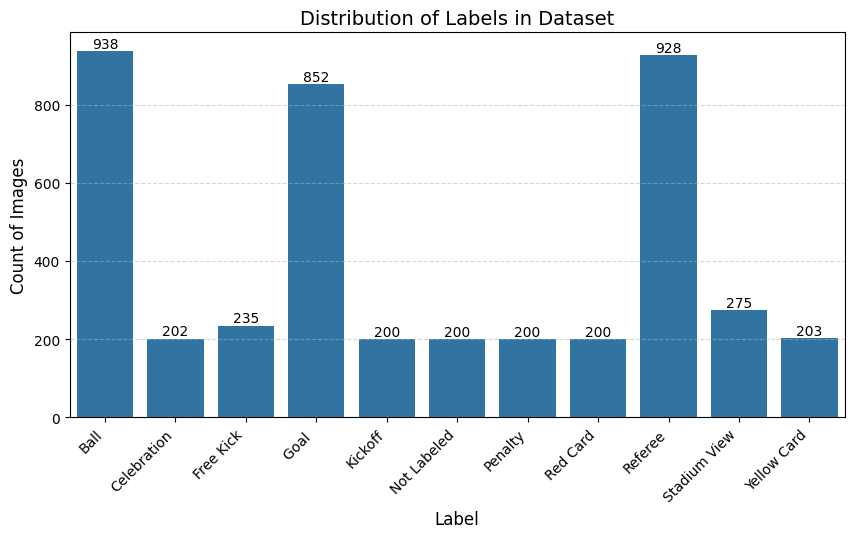

In [11]:
# Plot the labels
plot_label_counts(y)

## Create train and test datasets

In [12]:
# Prepare to split into train and test datasets for modeling
from sklearn.model_selection import train_test_split # import necesary library
test_size = 0.20 # global test size variable

In [13]:
# Import additional torch modules
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchsummary import summary

In [14]:
# Train-test split
index_train, index_test, X_train, X_test, y_train, y_test = train_test_split(index, X, y, test_size=test_size, random_state=random_state)

In [15]:
print("X_train shape:", X_train.shape)  # check shape of the train X array which should be (num_samples, num channels, img_dim, img_dim)
print("X_test shape:", X_test.shape)  # check shape of the test X array which should be (num_samples, num channels, img_dim, img_dim)
print("y_train length:", len(y_train)) # check train label length which should be num_samples
print("y_test length:", len(y_test)) # check test label length which should be num_samples

X_train shape: torch.Size([1717, 3, 224, 224])
X_test shape: torch.Size([430, 3, 224, 224])
y_train length: 1717
y_test length: 430


In [16]:
# Use TensorDataset instead of a custom dataset class
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

## Count and visualize the class distribution between train and test sets

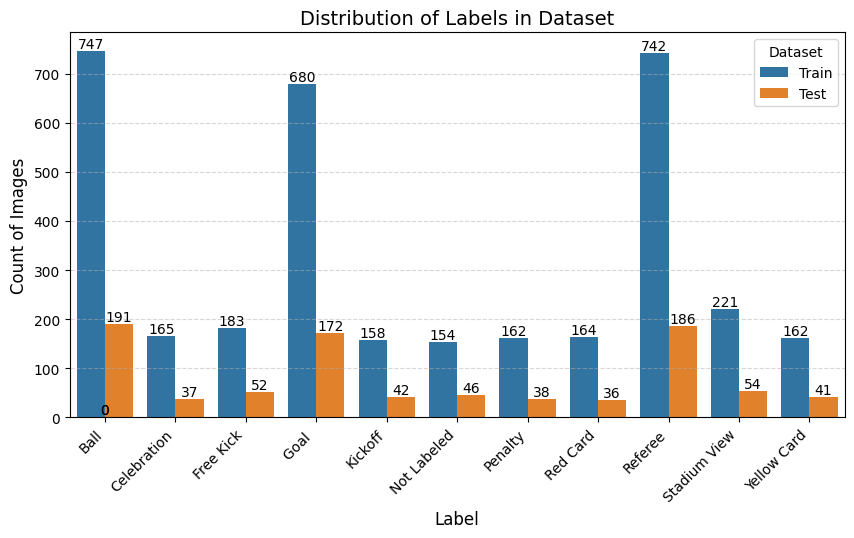

In [17]:
# Plot comparison of label distribution between the train and test sets
plot_label_counts(y_train, y_test)

## Visualize some images to confirm successful prep

In [18]:
# Define function to show an image where x is an image
def show_img(x, title="", bot=""):
    if isinstance(x, torch.Tensor):  # check whether the image is in tensor formate
        x = x.detach().cpu().numpy()  # if it is convert to NumPy and ensure it is moved to CPU
    if x.ndim == 3 and x.shape[0] in [1, 3]:  
        x = x.transpose(1, 2, 0)  # convert from (C, H, W) to (H, W, C) to work with imshow
    plt.imshow(x)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel(bot)
    plt.title(title, fontsize=10)
    plt.plot()

In [19]:
# Define function to show some number of images where X is an array of images, y is an array of labels, and n_images is the number of images to be displayed
import math
def display_images(X, y, index, n_images, data):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j=0
    for i in random.sample(range(len(X)), n_images):
        # Revert the multi-hot encoded label index to the labels that are present for display
        present_labels = []
        index_to_label = {v: k for k, v in label_to_idx.items()}
        present_labels = [index_to_label[i] for i, value in enumerate(y[i]) if value == 1]
        # Plot images with labels
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(X[i], title=", ".join(label.strip() for label in present_labels), bot=f"Image {list(data.keys())[index[i]]}") # Note, the image # is from the image dictionary and comes from the filename in the original dataset
        plt.plot()
        j += 1
    plt.tight_layout()

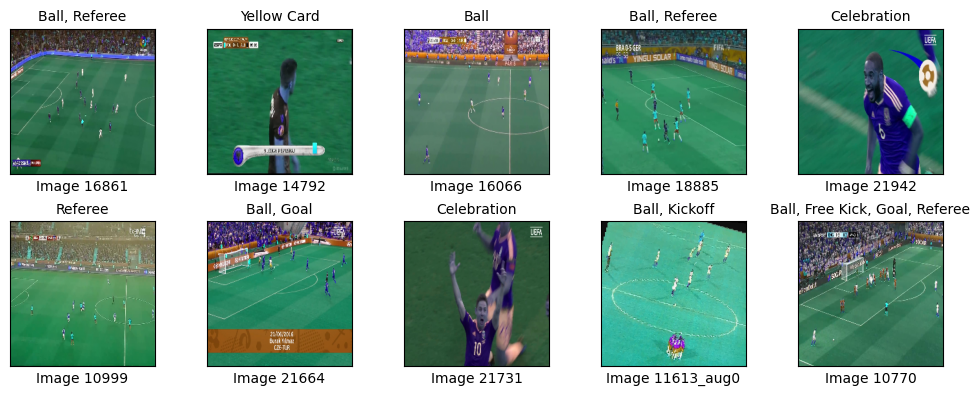

In [20]:
# Preview Train data
# Set the number images to preview
n_images_train = 10
# Show the images
display_images(X_train, y_train, index_train, n_images_train, data)

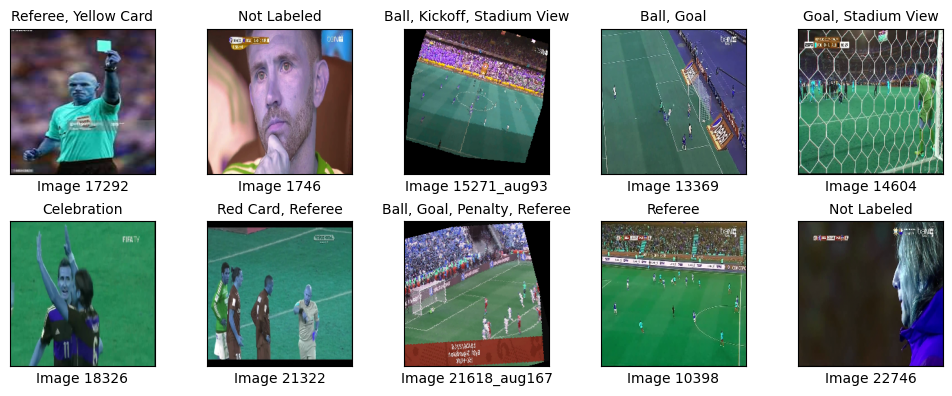

In [25]:
# Preview Test data
# Set the number images to preview
n_images_test = 10
# Show the images
display_images(X_test, y_test, index_test, n_images_test, data)

# Model

In [22]:
# Create global batch size variable
batch_size = 32

In [23]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [24]:
# Check DataLoader output
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)  # Expected: torch.Size([32, 3, 224, 224]) torch.Size([32, num_classes])
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 11])
